## Desafio 1

Cargamos las librerias necesarias

In [1]:
#!pip install seaborn
#!pip install gmaps

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import geopandas as gpd
import re
import time
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import mode
from scipy.special import erfc
import matplotlib.ticker as ticker
from shapely import wkt

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'shapely'

In [ ]:
CantidadMinimaDePropiedades = 50

---
## Cargamos los datos

In [29]:
DF = pd.read_csv("properatti.csv", sep=",")

---
## Conociendo el dataset y limpieza grosera...
<br>
Obtenemos algo de información del dataset

In [30]:
DF.info()

# Revisamos si son consistentes los tipos de datos que determinó pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

<li>Hay 121219 registros, veamos algunos...</li>

In [31]:
DF.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


---
<li>Dejamos las columnas por aca...</li><br>
Tomamos como referencia el PDF<br/>
<ul>
<li><b>Unnamed 0</b>: ID de registro</li>
<li><b>operation</b>: Operación del aviso (sell, rent)</li>
<li><b>property_type</b>: Tipo de la propiedad (house, apartment, ph)</li>
<li><b>place_name</b>: Nombre del lugar</li>
<li><b>place_with_parent_names</b>: Nombre del lugar + nombre de sus ‘padres’</li>
<li style="color:red"><b>country_name</b>: No están en el PDF... titulo auto-descriptivo?</li>
<li style="color:red"><b>state_name</b>: No están en el PDF... titulo auto-descriptivo?</li>
<li><b>geonames_id</b>: ID de geonames del lugar (si está disponible)</li>
<li><b>lat-lon</b>: Latitud, longitud</li>
<li style="color:red"><b>lat</b>: No están en el PDF... ToDo: verificar si se corresponde con lat-lon</li>
<li style="color:red"><b>lon</b>: No están en el PDF... ToDo: verificar si se corresponde con lat-lon</li>
<li><b>price</b>: Precio original del aviso</li>
<li><b>currency</b>: Moneda original del aviso (ARS, USD)</li>
<li><b>price_aprox_local_currency</b>: Precio del aviso en moneda local (ARS)</li>
<li><b>price_aprox_usd</b>: Precio aproximado en USD</li>
<li><b>surface_total_in_m2</b>: Superficie en m2</li>
<li><b>surface_covered_in_m2</b>: Superficie cubierta en m2</li>
<li><b>price_usd_per_m2</b>: Precio en USD/m2</li>
<li><b>price_per_m2</b>: Precio por m2</li>
<li><b>floor</b>: N° de piso, si corresponde</li>
<li><b>rooms</b>: Ambientes</li>
<li style="color:red"><b>expenses</b>: No están en el PDF... ToDo: Las expensas estarán expresadas en moneda local?</li>
<li><b>properati_url</b>: URL en Properati</li>
<li><b>description</b>: Descripción</li>
<li><b>title</b>: Título</li>
<li><b>image_thumbnail</b>: URL de un thumbnail de la primera foto</li>
</ul>

<h3 style="color:red">¿Podemos confiar en el detalle de columnas del PDF?</h3>
<h4>Parace que no están actualizadas las columnas, estarán bien las descripciones? Por ejemplo "floor".. indica el número de piso en un depto o en casas indica la cantidad de plantas?</h4>
<br><br><br>

In [32]:
DF.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

---
<li>Primera vista de los datos... Renombrando columnas</li>

In [33]:
DF.describe()

,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,121220.000000,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,60609.500000,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,34993.344153,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,0.000000,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,30304.750000,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,60609.500000,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,90914.250000,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,121219.000000,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


---
<li>¿Hay columnas que tengan un único valor?</li>
<li>¿La columna Unnamed: 0 puede que sea un ID único?</li>

In [34]:
DF.nunique()

Unnamed: 0                    121220
operation                          1
property_type                      4
place_name                      1060
place_with_parent_names         1164
country_name                       1
state_name                        28
geonames_id                      646
lat-lon                        47203
lat                            46495
lon                            46522
price                           9746
currency                           4
price_aprox_local_currency     10364
price_aprox_usd                10364
surface_total_in_m2             1687
surface_covered_in_m2            995
price_usd_per_m2               25567
price_per_m2                   25185
floor                            182
rooms                             31
expenses                         982
properati_url                 121220
description                   104055
title                          72705
image_thumbnail               114389
dtype: int64

---
<LI>A ver los nulos...</LI>

In [35]:
DF.isnull().sum(axis = 0)

Unnamed: 0                         0
operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
properati_url                      0
description                        2
title                              0
image_thumbnail                 3112
dtype: int64

---
<li>Cambiamos el nombre de algunas columnas, solo por comodidad</i>

In [36]:
DF.rename(columns={'Unnamed: 0': 'ID', 'properati_url': 'URL'}, inplace=True)


# Eliminando registros claramente mal cargados. Son sólo 3 filas

In [37]:
DF = DF[~(DF['currency'].isin(['USD', 'ARS', np.NaN]) == False)]

<h1>BUSCANDO DUPLICADOS</h1>

In [38]:
DF.loc[(DF['price'] <= 0), 'price'] = np.NaN
DF.loc[(DF['price'] <= 0), 'price_aprox_usd'] = np.NaN
DF.loc[(DF['price_aprox_usd'] <= 0), 'price_aprox_usd'] = np.NaN

In [39]:
# DUPLICADOS en todas las columnas, sacando ID
DF.duplicated(DF.columns.tolist()[1:]).sum()
# No hay..             

0

In [40]:
# Veamos si hay filas duplicadas en columnas "importantes"...
Columnas = ['property_type',
            'place_with_parent_names', 
            'lat-lon',
            'price',
            'currency',
            'price_aprox_usd',
            'surface_covered_in_m2',
            'surface_total_in_m2',
            'title',
            'rooms',
            'floor']

DupesDF = DF.duplicated(Columnas, keep='first')
print(f'Rows duplicadas: {DupesDF.sum()} de {len(DF)} ({round((DupesDF.sum()/len(DF))*100, 2)}%)')


Rows duplicadas: 8327 de 121217 (6.87%)


<h1 style=color:red>DROPEO DE FILAS DUPLICADAS</h1>

In [41]:
# Dropeamos las filas duplicadas..
DF = DF.loc[~DupesDF]

---
# Buscando filas duplicadas con distinta moneda

In [42]:
# Cuando está duplicada la misma propiedad con distinta moneda, nos quedamos con la que esté mas cerca de la media expresada en USD
Cols = ['property_type','place_with_parent_names', 'lat-lon','price','surface_covered_in_m2','surface_total_in_m2','rooms','floor']

# Busco todas las filas duplicadas
DupesRowIndex = DF.duplicated(Cols, keep=False)
print(f'Rows duplicadas: {DupesRowIndex.sum()} de {len(DF)} ({round((DupesDF.sum()/len(DF))*100, 2)}%)')

# Obtengo la media por cada tipo de propiedad. No necesito ser muy especifico, sólo queremos obtener la propiedad con datos "mas reales"
MeanByPropertyType = DF.groupby('property_type')['price_aprox_usd'].mean()
MeanByPropertyType = dict(zip(MeanByPropertyType.index, MeanByPropertyType.values))
IdRows2Delete = np.array([], dtype=int)

# Recorro los grupos para determinar cual de las filas está mas cerca de la media
for name, group in DF[DupesRowIndex].groupby(Cols,dropna=False)['ID']:
    tmp = DF[DF['ID'].isin(group)][['ID','property_type','price_aprox_usd']]
    tmp['closets'] = abs(tmp['price_aprox_usd']-MeanByPropertyType[tmp.iloc[0]['property_type']])
    IdRows2Delete = np.concatenate((IdRows2Delete, tmp.sort_values(by='closets', ascending=True)[1:]['ID'].tolist()))
    
print(f'\x1b[31m\">>> Elimino {IdRows2Delete.size} filas\"\x1b[0m')
DF = DF[(DF['ID'].isin(IdRows2Delete) == False)]


Rows duplicadas: 7712 de 112890 (7.38%)
">>> Elimino 4569 filas"


## Seguimos buscando duplicados

In [43]:
# Veamos si hay filas duplicadas en columnas "importantes"...
Columnas = ['property_type','place_with_parent_names', 'lat-lon', 'price_aprox_usd', 'surface_total_in_m2', 'rooms', 'title']

DupesDF = DF.duplicated(Columnas, keep='first')
print(f'Rows duplicadas: {DupesDF.sum()} de {len(DF)} ({round((DupesDF.sum()/len(DF))*100, 2)}%)')

print(f'\x1b[31m\">>> Elimino {DupesDF.sum()} filas\"\x1b[0m')
#DF = DF[~DupesDF]

Rows duplicadas: 1670 de 108321 (1.54%)
">>> Elimino 1670 filas"


# Hay registros que son "pruebas", contienen la palabra FALSA en la descripción

In [44]:
DF = DF[~(DF.description.str.contains('FALSA') == True)]
DF.shape[0]

108317

<H1>COLUMS STATS</H1>

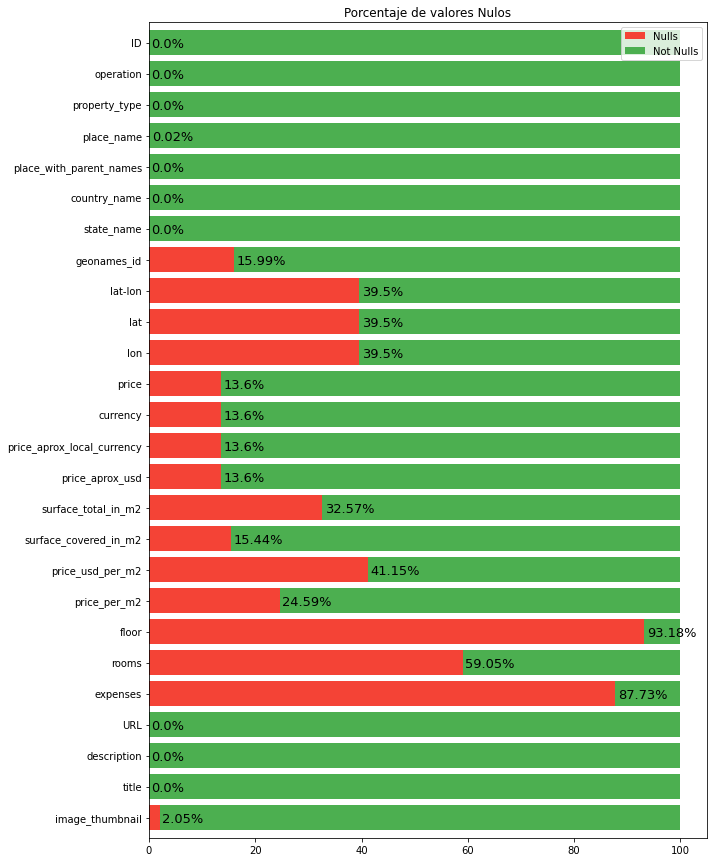

In [45]:
# Graficamos los valores nulos en cada columna
Rows = len(DF)

Nulos = DF.isnull().sum();
DFN = pd.DataFrame(Nulos/Rows*100)
DFN.rename(columns={0:'Nulls'}, inplace=True)
DFN['Not Nulls'] = 100-DFN['Nulls']

ax = DFN.plot(
        kind='barh', 
        stacked=True, 
        figsize=(10,15), 
        width=0.8, 
        color=['#f44336', '#4caf50'],
        title="Porcentaje de valores Nulos"
)

for i, v in enumerate(DFN.Nulls):
    ax.text(v+.5, 
              i+.15, 
              str(round(DFN.Nulls[i], 2))+'%', 
              fontsize=13)
    
ax.invert_yaxis()

<AxesSubplot:>

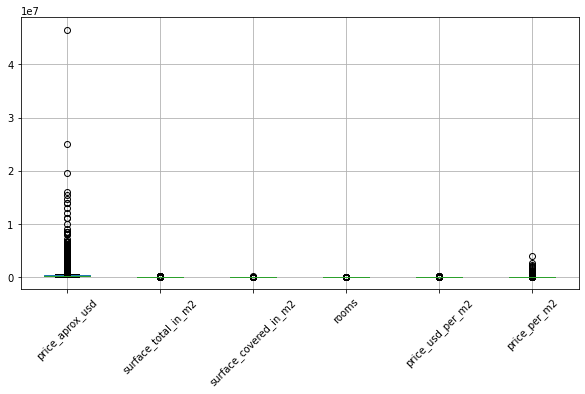

In [46]:
DF[['price_aprox_usd', 
    'surface_total_in_m2', 
    'surface_covered_in_m2', 
    'rooms',
    'price_usd_per_m2', 
    'price_per_m2']].boxplot(figsize=(10,5), rot=45)

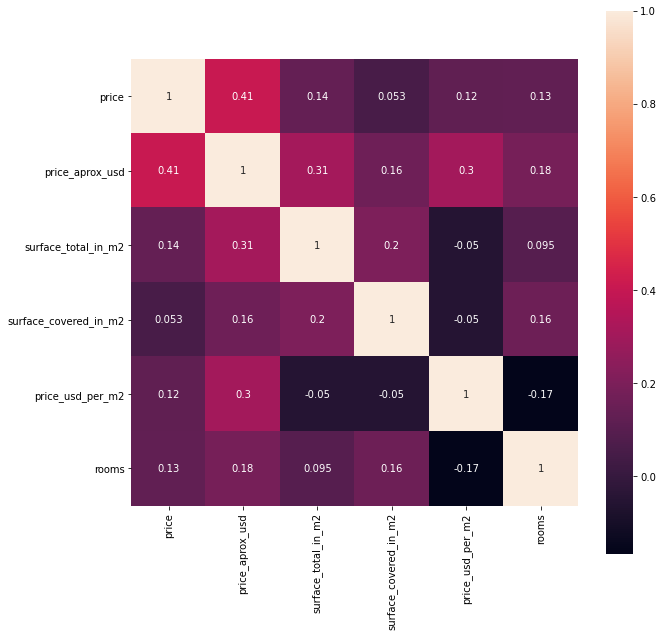

In [47]:
#Correlacion de variables
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[[
    'price',
    'price_aprox_usd',
    'surface_total_in_m2',
    'surface_covered_in_m2',
    'price_usd_per_m2',
    'rooms'
]].corr() , square=True, annot=True, ax=ax);

In [48]:
# Correlación entre columnas numéricas
# ==============================================================================

def Matrix2Tidy(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['Variable1','Variable2','r']
    corr_mat = corr_mat.loc[corr_mat['Variable1'] != corr_mat['Variable2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)    
    return(corr_mat)


corr_matrix = DF.select_dtypes(include=['float64', 'int']).corr(method='pearson')
Matrix2Tidy(corr_matrix).head(10)

,Variable1,Variable2,r,abs_r
57,price_aprox_local_currency,price_aprox_usd,1.000000,1.000000
69,price_aprox_usd,price_aprox_local_currency,1.000000,1.000000
120,price_per_m2,price,0.489075,0.489075
48,price,price_per_m2,0.489075,0.489075
44,price,price_aprox_usd,0.411663,0.411663
68,price_aprox_usd,price,0.411663,0.411663
55,price_aprox_local_currency,price,0.411663,0.411663
43,price,price_aprox_local_currency,0.411663,0.411663
83,surface_total_in_m2,price_aprox_usd,0.310806,0.310806
71,price_aprox_usd,surface_total_in_m2,0.310806,0.310806


In [24]:
DF.isnull().sum().sort_values()

ID                                 0
operation                          0
property_type                      0
place_with_parent_names            0
country_name                       0
state_name                         0
URL                                0
title                              0
description                        2
place_name                        23
image_thumbnail                 2218
price_aprox_local_currency     14735
price                          14736
price_aprox_usd                14736
currency                       14736
surface_covered_in_m2          16727
geonames_id                    17318
price_per_m2                   26632
surface_total_in_m2            35278
lat                            42790
lat-lon                        42790
lon                            42790
price_usd_per_m2               44577
rooms                          63961
expenses                       95027
floor                         100925
dtype: int64

<hr />
<h1 style=color:blue;font-weight:bold>Inicio Procesamiento Datos</h1><br>
<hr />

<h1>Columna operation</h1>

* Sólo 1 valor, no hay nulos.... pero... en la URL parece que se indica el tipo de operación... salteamos algunas columnas y vamos a URL

In [25]:
DF['operation'].nunique()

1

<h1>Columna properati_url</h1>

Notas:

* Parece que después del dominio hay un "id", seguido del tipo de operación, después el tipo de propiedad, y el resto son keywords separadas por _
* parece que la ultima keyword es el nombre de la inmobiliaria

In [26]:
DF['URL'].head()

0    http://www.properati.com.ar/15bo8_venta_ph_mat...
1    http://www.properati.com.ar/15bob_venta_depart...
2    http://www.properati.com.ar/15bod_venta_depart...
3    http://www.properati.com.ar/15boh_venta_ph_lin...
4    http://www.properati.com.ar/15bok_venta_depart...
Name: URL, dtype: object

In [27]:
if DF['URL'][0].startswith('http') == False:
    raise Exception('Perdiste! Ya ejecutaste esta celda... los datos ya no son consistentes! Dale play a todo de nuevo!')

# Saco el dominio y el ID para simplificar el resto de los regexs
DF['URL'].replace('^http(s|)://([^/]+)/([^_]+)_', '', regex=True, inplace=True)

# Ya que estoy limpio caracteres extraños...
DF['URL'].replace('([^\w\d_-])', '', regex=True, inplace=True)

# Si voy a usar _ como caracter que separa, me aseguro que no exista más de uno seguido
DF['URL'].replace(r'(__+)', '_', regex=True, inplace=True)

In [ ]:
# veo si todo va bien...
DF['URL']

In [ ]:
# Obtengo el tipo de operacion... variable en español para no confundirse con los parámetros de insert :)
URL_Operacion = DF['URL'].replace(r'^([^_]+)_.*', r'\1', regex=True)
URL_Operacion.unique()

In [ ]:
(URL_Operacion != 'venta').sum()


lo bueno es que hay 3 valores consistentes con un tipo de operación..<br>
lo malo... el dataset estará bien? la columna Operation estará bien<br><br>
Almacenamos este dato en una nueva columna para después ver si los precios de los "alquileres" no son outliers y descartar esas filas

In [ ]:
# Agrego la columna URL_Operation después de la columna URL
DF.drop(['URL_Operation'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('URL')+1, 'URL_Operation', URL_Operacion)

---
<B>Hago lo mismo que hice con tipo de operación, pero ahora obtengo el tipo de propiedad</B><br>
Lo podría haber hecho todo en una vez... pero así es más facil de entender después...

In [ ]:
URL_TipoPropiedad = DF['URL'].replace(r'^[^_]+_([^_]+)_.*', r'\1', regex=True)
URL_TipoPropiedad.describe()

In [ ]:
URL_TipoPropiedad.unique()

Parece que tiene mayor especifidad que la columna property_type... la agrego...

In [ ]:
# Agrego la columna URL_property_type después de la columna URL_Operation
DF.drop(['URL_property_type'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('URL_Operation')+1, 'URL_property_type', URL_TipoPropiedad)

---
<b>Ahora obtengo las keywords!</b><br>
* Al final, hay N posiciones donde está el nombre del vendedor, pero no es facil sacarlo ya que hay muchas posibilidades, ademas parece que properati agrega letras al azar cuando el nombre está repetido. 

In [ ]:
# Separo las keys y armo una lista para cada fila
URL_Tags = DF['URL'].replace(r'^[^_]+_[^_]+_[^_]+_(.*)$', r'\1', regex=True)

# Estos replaces los obtuve despues de analizar los datos en las celdas posteriores...
URL_Tags.replace(r'subte([^_]+)', 'subte', regex=True, inplace=True)
URL_Tags.replace(r'av\-([^_]+)', 'avenida', regex=True, inplace=True)
URL_Tags.replace(r'avenida([^_]+)', 'avenida', regex=True, inplace=True)
URL_Tags.replace(r'_sum_', '_S.U.M_', regex=True, inplace=True)

# Lo transformo a lista
URL_Tags = URL_Tags.str.split("_", expand = False)

In [ ]:
# Agrego la columna URL_Keywords después de la columna URL_location
DF.drop(['URL_Keywords'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('URL_property_type')+1, 'URL_Keywords', URL_Tags)

In [ ]:
DF['URL_Keywords']

---
Vamos a crear una nueva columna con las keys más populares... dependiendo el modelo, después podremos convertirlas en dummys<br>
También está la duda de si filtrar según URL_property_type es mejor o no que property_type... veremos al momento de aplicar el modelo

In [ ]:
# Palabras Top Keywords
TopsKeysWords = {
    'S.U.M': 'amenities',
    'dueno-': 'dueno',
    'mascota': 'petfriendly',
    'av-': 'avenida',
    'avenida': 'avenida',
    'credito': 'banco',
    'banco': 'banco',
    'amenities': 'amenities',
    'amoblado': 'amoblado',
    'balcon': 'extras',
    'toilette': 'extras',
    'baulera': 'extras',
    'dependencias': 'dependencias',
    'electrogeno': 'electrogeno',
    'estrenar': 'estrenar',
    'garage': 'cochera',
    'gimnasio': 'gimnasio',
    'hidromasaje': 'lujoso',
    'impecable': 'impecable',
    'jardin': 'extras',
    'kitchinete': 'extras',
    'lavadero': 'dependencias',
    'lujoso': 'lujoso',
    'luminoso': 'luminoso',
    'parrilla': 'parrilla',
    'patio': 'extras',
    'piscina': 'pileta',
    'placard': 'extras',
    'quincho': 'quincho',
    'sauna': 'lujoso',
    'sotano': 'extras',
    'subte': 'subte',
    'suite': 'extras',
    'tenis': 'lujoso',
    'terraza': 'terraza',
    'vestidor': 'extras',
    'vista': 'vista',
    'golf': 'amenities',
    'seguridad': 'seguridad'
}

TopsKeysWordsRx = '('+'|'.join(TopsKeysWords.keys())+')'


In [ ]:
# Creamos la columna URL_TopKeywords... dummys world!

DF.drop(['URL_TopKeywords', 'URL_TopKeywordsCategory'], axis=1, inplace=True, errors='ignore')
#DF.insert(DF.columns.get_loc('URL_Keywords')+1, 'URL_TopKeywords', DF.apply(lambda row: [x for x in row['URL_Keywords'] if x in KeysByType[row['property_type']]], axis=1))
DF.insert(DF.columns.get_loc('URL_Keywords')+1, 'URL_TopKeywords',DF.apply(lambda row: [x for x in row['URL_Keywords'] if re.match(TopsKeysWordsRx, x)], axis=1))
DF.insert(DF.columns.get_loc('URL_TopKeywords')+1, 'URL_TopKeywordsCategory',DF.apply(lambda row: [TopsKeysWords.get(x) for x in row['URL_Keywords'] if re.match(TopsKeysWordsRx, x)], axis=1))
DF['URL_TopKeywordsCategory'] = DF['URL_TopKeywordsCategory'].map(set).apply(list)



In [ ]:
# Para generar dummys de las categorias de keywords
DF.URL_TopKeywordsCategory.apply(pd.Series).stack().str.get_dummies().sum(level=0).add_prefix('URL_dummy_')

---
<h1>Columna property_type</h1>

* Sólo 4 valores posibles, sin nulos
* Parece que URL_property_type es más especifica... que bien nos vendría saber algo del modelo....

In [ ]:
DF['property_type'].describe()

In [ ]:
DF['property_type'].isnull().sum()

In [ ]:
DF.groupby('property_type')['URL_property_type'].value_counts(True)*100

## Hay algunos registros donde "property_type" difiere al que obtuvimos de la URL

In [ ]:
# Hacemos un replace para facilitar el query al buscar diferencias
replace_dict = {
    'departamentos': 'apartment',
    'departamento': 'apartment',
    'casa': 'house',
    'local': 'store',
    'ph': 'PH'
}
DF['URL_property_type'] = DF['URL_property_type'].replace(replace_dict)

In [ ]:
idxDifiereTipo = (DF.property_type != DF.URL_property_type)
print(f'Hay {idxDifiereTipo.sum()} registros donde no coincide el tipo de propiedad.')
DF = DF[~idxDifiereTipo]

Por el título arreglamos el dato de tipo de propiedad

In [ ]:
# Departamentos que son casas
IdxDepto2Casa = ((DF['property_type'] == 'apartment') 
    & (DF['title'].str.contains('casa ', case=False) == True)
    & (DF['title'].str.contains('edificio|departament|tipo casa', case=False) == False)
   ) #

print(f'Cambio a property_type=house según el title: {IdxDepto2Casa.sum()} registros')
DF.loc[IdxDepto2Casa, 'property_type'] = 'house'

In [ ]:
# Casa/PH que son departamentos...
IdxCasa2Depto = ((DF['property_type'].isin(['house', 'PH'])) 
    & (DF['title'].str.contains('departamento', case=False) == True)
    & (DF['title'].str.contains('casa|PH|chalet|propiedad|terreno', case=False) == False)
   )

print(f'Cambio a property_type=apartment según el title: {IdxCasa2Depto.sum()} registros')
DF.loc[IdxCasa2Depto, 'property_type'] = 'apartment'

In [ ]:
# Locales que son casas...
IdxLocales2Casa = ((DF['property_type'] == 'store') 
    & (DF['title'].str.contains('casa ', case=False) == True)
    & (DF['title'].str.contains('local', case=False) == False)
   )

print(f'Cambio a property_type=house según el title: {IdxLocales2Casa.sum()} registros')
DF.loc[IdxLocales2Casa, 'property_type'] = 'house'

In [ ]:
# Locales que son deptos...
IdxLocales2Deptos = ((DF['property_type'] == 'store') 
    & (DF['title'].str.contains('departament', case=False) == True)
    & (DF['title'].str.contains('local', case=False) == False)
   )

print(f'Cambio a property_type=apartment según el title: {IdxLocales2Deptos.sum()} registros')
DF.loc[IdxLocales2Deptos, 'property_type'] = 'apartment'

---
<h1>Columnas place_name, place_with_parent_names y country_name</h1>

* Parece que estas 3 columnas tienen información redundante
* country_name está contenida en place_whith_parent_name
* place_name tiene 23 datos nulos

In [ ]:
DF['country_name'].describe()

In [ ]:
DF['place_with_parent_names'].str[0:11].value_counts()
# Todos los datos son de argentina... después hay que verificarlo con lat-long

In [ ]:
if DF['place_with_parent_names'].str[:11].unique().size != 1 or DF['place_with_parent_names'].str[:11].unique()[0] != '|Argentina|':    
    raise Exception('Esta notebook está preparada sólo para Argentina')
else:
    print('Perfecto! place_with_parent_names es sólo de Argentina')
    


In [ ]:
DF['place_with_parent_names'].str[11:].str.count('\|').value_counts()
# Quedan de 1 a 4 pipes que separan niveles administrativos... vamos a separarlos..

In [ ]:
# Separamos descartando Argentina
NivelesAdministrativos = DF['place_with_parent_names'].str[11:].str.strip('|').str.split("|", expand = True)


In [ ]:
# Veamos en que niveles son nulos...
NivelesAdministrativos.isnull().sum()

In [ ]:
# Agrego las columnas después de place_with_parent_names...
DF.drop(['NivelAdm1', 'NivelAdm2', 'NivelAdm3', 'NivelAdm4', 'NivelAdm5'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('place_with_parent_names')+1, 'NivelAdm1', NivelesAdministrativos[0])
DF.insert(DF.columns.get_loc('place_with_parent_names')+2, 'NivelAdm2', NivelesAdministrativos[1])
DF.insert(DF.columns.get_loc('place_with_parent_names')+3, 'NivelAdm3', NivelesAdministrativos[2])
DF.insert(DF.columns.get_loc('place_with_parent_names')+4, 'NivelAdm4', NivelesAdministrativos[3])

---
 Analizando niveles administrativos...

In [ ]:
DF['NivelAdm1'].value_counts()
# parecen datos normalizados..

In [ ]:
DF['NivelAdm2'].value_counts()

In [ ]:
DF['NivelAdm3'].value_counts()

In [ ]:
DF['NivelAdm4'].value_counts()

# DATO! Parece que el nivelAdm4 indica si es un barrio privado

In [ ]:
# Creamos una nuevo columna que indique si es barrio privado o no
DF.drop(['EsBarrioCerrado'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('NivelAdm4')+1, 'EsBarrioCerrado', DF['NivelAdm4'].isnull() != True)

In [ ]:
# Vamoslo agrupado por property_type
DF.groupby('EsBarrioCerrado')['property_type'].value_counts()

In [ ]:
# Vamoslo agrupado por URL_property_type
DF.groupby('EsBarrioCerrado')['URL_property_type'].value_counts()

In [ ]:
DF[DF['EsBarrioCerrado'] == True][['NivelAdm4']].value_counts()
# Y todos los barrios son de nordelta... 

In [ ]:
# Nordelta tiene propiedades que no son barrios cerrados?
DF[DF['EsBarrioCerrado'] == False].loc[DF['NivelAdm3'] == 'Nordelta']['description'].sample(20)
# En las descripciones se ve que la algunos dicen en que barrio está...
# y en https://es.wikipedia.org/wiki/Nordelta dice que son todos barrios cerrados... era obvio, no?

In [ ]:
# Voy a intentar determinar el barrio cerrado al que pertenecen a partir de la descripción
RegexsBarriosCerrados = {}
PattCommonWords = re.compile("\s(de|los|el|la|del|la|las|lago)\s", re.IGNORECASE)

for barrio in DF.loc[DF['NivelAdm3'] == 'Nordelta'].loc[DF['EsBarrioCerrado'] == True]['NivelAdm4'].value_counts().index:
    ReWords = '.*\s('+PattCommonWords.sub(' ', ' '+barrio.lower()+' ').replace('barrio', '').strip().replace(' ', '|')+')\s.*'
    RegexsBarriosCerrados[barrio] = re.compile(ReWords, re.IGNORECASE)

def CompletarBarrio(row):
    # Si, Esta forma de asignar los valores tiene un problema con barrios que comparten palabras claves
    if row['NivelAdm3'] == 'Nordelta' and row['EsBarrioCerrado'] == False and row['NivelAdm4'] == None:
        for i in RegexsBarriosCerrados:
            if (bool(RegexsBarriosCerrados[i].match(' '+row['description']+' '))):
                row['NivelAdm4'] = i
                row['EsBarrioCerrado'] = True
                break;
    return row
    


In [ ]:
# Antes de Aplicar la funcion...
DF['NivelAdm4'].value_counts()


In [ ]:
# Aplicamos la funcion... preparate un cafe...
DF = DF.apply(CompletarBarrio, axis=1)

In [ ]:
# Después de aplicar la funcion...
DF['NivelAdm4'].value_counts()


In [ ]:
DF['EsBarrioCerrado'].value_counts()

In [ ]:
# Ahora vamos a marcar TODOS los que según la descripción pertenecen a un barrio cerrado/privado/semi
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

# Uso la descripción para asignar EsBarrioPrivado
DF.loc[(DF['EsBarrioCerrado'] == False) & (DF['description'].str.contains('barrio\s(semi|cerrado|privado)', case=False) == True), 'EsBarrioCerrado'] = True
DF.loc[(DF['EsBarrioCerrado'] == False) & (DF['description'].str.contains('en country', case=False) == True), 'EsBarrioCerrado'] = True
DF.loc[(DF['EsBarrioCerrado'] == False) & (DF['place_with_parent_names'].str.contains('barrio\s(semi|cerrado|privado)', case=False) == True), 'EsBarrioCerrado'] = True


In [ ]:
DF['EsBarrioCerrado'].value_counts()

# El objetivo de todo esto era normalizar los distintos niveles de ubicación
* Vamos a realizar imputaciones siguiendo un orden de "cercania", por lo tanto queremos que cada nivel incluya el anterior para que sean únicos

In [ ]:
DF['NivelAdm2'] = DF['NivelAdm1']+'>'+DF['NivelAdm2']
DF['NivelAdm3'] = DF['NivelAdm2']+'>'+DF['NivelAdm3']
DF.loc[DF['NivelAdm2'].isna(), 'NivelAdm2'] = None
DF.loc[DF['NivelAdm3'].isna(), 'NivelAdm3'] = None

---
<h1>Columnas geonames_id, lat-lon, lat, lon</h1>


In [ ]:
# Checkpoint! Backup
Bkp = DF

In [ ]:
# datos faltantes de lat
DF['lat'].notnull().sum()

In [ ]:
# si hay un valor en lat también está en log
DF['lat'].notnull().sum() - DF['lon'].notnull().sum()

In [ ]:
DF['lat-lon'].notnull().sum()
# lat-lon parece que tiene el valor separado en las columas lat-lon... revisemos que sean iguales

In [ ]:
X = DF[:][['lat-lon','lat','lon']].copy()
ParsedLatLon = X['lat-lon'].str.split(",", expand = True).astype(float)
X['lat2'] = ParsedLatLon[0]
X['lon2'] = ParsedLatLon[1]
X['diff'] = abs(X['lat']-X['lat2']) + abs(X['lon']-X['lon2'])
MaxDiff = round(X['diff'].max(), 10)

print(f'Diferencias en los primeros 10 decimales: {MaxDiff}')
if MaxDiff != 0:
    raise Exception('Hay inconsistencias entre la columna lat-lon con lat y lon')
else:
    print('Perfecto! lat-lon es igual a las columnas lat y lon')


In [ ]:
# Podemos completar lat-lon con geoname? parece que si...
DF[DF['geonames_id'].notnull() & DF['lat-lon'].isnull()][['geonames_id','lat-lon']]


In [ ]:
# Podemos completar geoname con lat-lon? parece que si...
DF[DF['geonames_id'].isnull() & DF['lat-lon'].notnull()][['geonames_id','lat-lon']]


# Usamos un poligono de la republica argentina para sacar outliers de lat-lon
* Si algún punto está fuera del territorio argentino, lo descartamos

In [ ]:
GeoAR = gpd.read_file('datos/pais.shp')

In [ ]:
DFPoints = gpd.GeoDataFrame(DF['ID'], geometry=gpd.points_from_xy(DF.lon, DF.lat)) # , crs='EPSG:4326'
DFArgentum = gpd.sjoin(DFPoints, GeoAR, op='within')

In [ ]:
ValidGeoPointsID = DFArgentum.index.tolist()
InvalidPoints = (DF['ID'].isin(ValidGeoPointsID) == False) & DF['lat-lon'].notnull()

In [ ]:
DF.shape[0] - InvalidPoints.shape[0]

## Saco lat-lon inválidos

In [ ]:
DF.loc[InvalidPoints, 'lat-lon'] = np.NaN
DF.loc[InvalidPoints, 'lat'] = np.NaN
DF.loc[InvalidPoints, 'lon'] = np.NaN

In [ ]:
# Creo la columna lat-lon-geopoint
DF.drop(['lat-lon-geopoint'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('lat-lon')+1, 'lat-lon-geopoint', gpd.points_from_xy(DF.lon, DF.lat))
#DF.loc[DF['lat-lon'].isnull(), 'lat-lon-geopoint'] =  # Para facilitar selects usando isnull

In [ ]:
# Cargo DV de geonames argentinos
GN = pd.read_csv("datos/geonames_AR.csv", sep="\t")
# Me quedo sólo con los tipos de puntos que necesito y columnas específicas
GN = GN[GN['feature_code'].isin(['ADM1', 'ADM2', 'ADM3', 'ADM4', 'ADMD', 'PPL', 'PPLX', 'PPLA', 'PPLA2', 'PPLA3', 'PPLA4', 'PPLA5'])][['geonameid','name','longitude','latitude']]

# Armo una cache de los puntos con CKDTree (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html)
GN_btree = cKDTree(np.array(list(GN.apply(lambda row: (row.longitude, row.latitude), axis=1))))

In [ ]:
# Saco geonames que no existan en la DB completa
ValidGeoNames = pd.merge(DF[['ID', 'geonames_id']], GN, left_on="geonames_id", right_on='geonameid')
DF.loc[(DF.ID.isin(ValidGeoNames.ID) == False), 'geonames_id'] = np.NaN

In [ ]:
# Agrego los datos del geoname
DF.drop(['geonames_id_name', 'geonames_id_lat', 'geonames_id_lon'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('geonames_id')+1, 'geonames_id_lon', None)
DF.insert(DF.columns.get_loc('geonames_id')+1, 'geonames_id_lat', None)
DF.insert(DF.columns.get_loc('geonames_id')+1, 'geonames_id_name', None)

<H1>Imputo GeoName por lat-lon</H1>

In [ ]:
# Creo la columna geonames_id_inputted
DF.drop(['geonames_id_inputted'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('geonames_id')+1, 'geonames_id_inputted', None)

# Marco como NO imputados los valores que ya existen
DF.loc[DF['geonames_id'].notnull(), 'geonames_id_inputted'] = 'Original'

def CompletarGeoNameIdByLatLon(row):
    if (np.isnan(row['geonames_id']) & row['lat-lon-geopoint'].is_valid):
        dist, idx = GN_btree.query(row['lat-lon-geopoint'], k=1)
        #idx = GNE_btree.query_ball_point(x=[row['longitude'], row['latitude']], r=0.00920*5, return_sorted=True)
        if (dist < 30) & idx >= 0:
            row['geonames_id'] = GN.iloc[idx]['geonameid']
            row['geonames_id_inputted'] = 'byGeoPoint'
    return row    

In [ ]:
# Veo cuantos valores no existen
DF['geonames_id_inputted'].value_counts(False, dropna=False)


In [ ]:
print(f'Geonames Faltantes pre-imputacion: {DF.geonames_id.isnull().sum()}\nImputando... Espere...')
DF = DF.apply(CompletarGeoNameIdByLatLon, axis=1)
print(f'Geonames Faltantes post-imputacion: {DF.geonames_id.isnull().sum()}')

In [ ]:
# Obtengo la moda (geonameid) agrupados por nivel Administrativo para imputar
MultiIdxbyKey = {}

for key in ['place_with_parent_names','NivelAdm1','NivelAdm2','NivelAdm3']:
    print(f'Moda geoname por {key}: ', end='')
    MultiIdxbyKey[key] = dict(DF.groupby([key])['geonames_id'].agg(lambda x: mode(x)[0]))
    print(len(MultiIdxbyKey[key]))


In [ ]:
def CompletarGeoNameId(row, key, dicc):
    if np.isnan(row['geonames_id']).any():
        NewVal = dicc.get(row[key])
        if NewVal:
            row['geonames_id'] = NewVal
    return row


In [ ]:
DF.loc[DF['geonames_id'].isnull(), 'geonames_id'] = np.NaN

for Col in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1']:
    print(f'Geonames Faltantes pre-imputacion {Col}: {DF.geonames_id.isnull().sum()}\nImputando... Espere...')
    Temp = DF[DF['geonames_id'].isnull()][[Col, 'geonames_id']].apply(CompletarGeoNameId, 
                                                                        axis=1, 
                                                                        key=Col, 
                                                                        dicc=MultiIdxbyKey[Col])
    Temp = Temp[Temp['geonames_id'].notnull()]
    DF.loc[Temp.index, 'geonames_id'] = Temp['geonames_id']
    DF.loc[Temp.index, 'geonames_id_inputted'] = 'by'+Col

print(f'Geonames Faltantes post-imputacion: {DF.geonames_id.isnull().sum()}')    

In [ ]:
# Tenemos algunas "localidades" que tienen mas de un geoname, fue por la imputación por cercania en la DB de geonames
DF.groupby('place_with_parent_names')['geonames_id'].nunique().sort_values(ascending=False)

In [ ]:
# Reviso como hice la imputacion
DF['geonames_id_inputted'].value_counts(False, dropna=False)

In [ ]:
# Vuelvo a joinear con los nuevos resultados
ValidGeoNames = pd.merge(DF[['ID', 'geonames_id']], GN, left_on="geonames_id", right_on='geonameid')
ValidGeoNames.index = ValidGeoNames.ID # para mantener indice

# Agrego la nueva info
DF['geonames_id_name'] = ValidGeoNames['name']
DF['geonames_id_lat'] = ValidGeoNames['latitude']
DF['geonames_id_lon'] = ValidGeoNames['longitude']

---
# Columna rooms

In [ ]:
DF.groupby('property_type')['rooms'].describe()

In [ ]:
DF.boxplot(column='rooms', by=['property_type'])

In [ ]:
# Creo una columna donde voy a indicar si los valores son imputados
DF.drop(['rooms_inputted', 'rooms_from_title', 'rooms_from_description'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('rooms')+1, 'rooms_from_title', np.NaN)
DF.insert(DF.columns.get_loc('rooms')+2, 'rooms_from_description', np.NaN)
DF.insert(DF.columns.get_loc('rooms')+3, 'rooms_inputted', None)
DF.loc[DF['rooms'].notnull(), 'rooms_inputted'] = 'Original'

In [ ]:
# No quiero locales con rooms
DF.loc[DF['property_type'] == 'store', 'rooms'] = np.NaN

In [ ]:
# Outliers de rooms
# Limito a Media + (STD * 3) = 7
DevStd = DF.groupby('property_type')['rooms'].std()
Media = DF.groupby('property_type')['rooms'].mean()
Topes = round(Media + (DevStd*3))
print(Topes)

In [ ]:
# Tomamos una muestra para ver si la columna "rooms" indica la cantidad de AMBIENTES o de DORMITORIOS
DF[DF.title.str.contains('(\d) ambientes', case=False, regex=True)][['rooms', 'title']].sample(20)


In [ ]:
# Tomamos una muestra para ver si la columna "rooms" indica la cantidad de DORMITORIOS o AMBIENTES
DF[DF.title.str.contains('(\d) dormit', case=False, regex=True)][['rooms', 'title']].sample(20)

En forma indistinta en la columna "rooms" figura la cantidad de ambientes o de dormitorios.<br>
Nunca vamos a poder obtener un grado de seguridad tal que nos permita diferenciar cuando se ingresó cantidad de "ambientes" o de "dormitorios".<br>
Decidimos mantener esa dicotomia al imputar desde el titulo/descripción

In [ ]:
# Intento obtener la cantidad de ambientes en el titulo y la descripcion. 
RegexPatt = re.compile("\s([1-7])\s+(amb|cuarto|habit|dormit)", re.IGNORECASE)

DF['rooms_from_title'] = DF[DF['title'].notnull()]['title'].str.extract(RegexPatt)[0].astype(float)
DF['rooms_from_description'] = DF[DF['title'].notnull()]['description'].str.extract(RegexPatt)[0].astype(float)

# en los casos que puden darse a error, confio en la columna rooms
DF.loc[DF.rooms_from_title.notnull() # Cuando encontré un dato
   & DF.rooms.notnull() # y ya tengo un dato de rooms
   & DF.title.str.contains('(\d\s*,\s*|\d\s*y\s*|\d\s*\/\s*|\.)([1-7])\s+(amb|cuarto|habit|dormit)', case=False, regex=True) # Intento evitar 1 y 2, 1,2, 1/2, 1.5
       , 'rooms_from_title'] = np.NaN

DF.loc[DF.rooms_from_description.notnull() # Cuando encontré un dato
   & DF.rooms.notnull() # y ya tengo un dato de rooms
   & DF.description.str.contains('(\d\s*,\s*|\d\s*y\s*|\d\s*\/\s*|\.)([1-7])\s+(amb|cuarto|habit|dormit)', case=False, regex=True) # Intento evitar 1 y 2, 1,2, 1/2, 1.5
       , 'rooms_from_description'] = np.NaN

# Cuando obtuve el mismo dato desde la descripcion y el titulo, me quedo solo con la del titulo
DF.loc[((DF.rooms_from_title > 0) & (DF.rooms_from_description > 0) & (DF.rooms_from_title == DF.rooms_from_description)), 'rooms_from_description'] = np.NaN

In [ ]:
# Imputo las filas que no tiene rooms
IdxFromTitle = (DF.rooms.isnull() & DF.rooms_from_title.notnull())
DF.loc[IdxFromTitle, 'rooms_inputted'] = 'byTitle'
DF.loc[IdxFromTitle, 'rooms'] = DF['rooms_from_title']

IdxFromDescription = (DF.rooms.isnull() & DF.rooms_from_description.notnull())
DF.loc[IdxFromDescription, 'rooms_inputted'] = 'byDescription'
DF.loc[IdxFromDescription, 'rooms'] = DF['rooms_from_description']

In [ ]:
# Establezco nro de rooms a los monoabientes segun el titulo
IdxMonoAmbientes = ((DF['property_type'] == 'apartment') 
                    & ((DF.description.str.contains('monoamb', case=False) == True) | (DF.title.str.contains('monoamb', case=False) == True)))
DF.loc[IdxMonoAmbientes, 'rooms_inputted'] = 'byMonoambiente'
DF.loc[IdxMonoAmbientes, 'rooms'] = 1

In [ ]:
# Hay algunas propiedades "especiales" que pueden distorsionar los datos, le cambiamos el tipo de propiedad
DF.loc[(
     (DF.title.str.contains('Hotel|Hostel|cabañas|venta\s(de\s|)complejo de|bloque|boutique|chacra|estancia', case=False, regex=True) == True)
    & (DF.title.str.contains('en complejo', case=False, regex=False) == False)
    & (DF.title.str.contains('casona|importante', case=False, regex=True) == False)
   ), 'property_type'] = 'complejo' #.shape #[['price', 'rooms', 'rooms_from_title', 'title', 'description']]

In [ ]:
# Hay algunas propiedades "especiales" que pueden distorsionar los datos, le cambiamos el tipo de propiedad
DF.loc[(
     (DF.property_type != 'complejo')
    & (DF.description.str.contains('\s(de Hotel|de Hostel|de cabañas|de cabanas|boutique|chacra|estancia)\s', case=False, regex=True) == True)
    & (DF.description.str.contains('en complejo', case=False, regex=False) == False)
    & (DF.description.str.contains('casona|importante', case=False, regex=True) == False)    
   ), 'property_type'] = 'complejo'
   #)][['price', 'rooms', 'rooms_from_title', 'title', 'description', 'surface_total_in_m2', 'price_aprox_usd', 'price_aprox_usd_inputted']]

In [ ]:
# Imputo (sobre-escribo) rooms en caso que una propiedad tenga más de 7 rooms, no sea un complejo y haya obtenido un dato menor del titulo/descripción
IdxRewriteRooms =  ((DF.rooms>7) 
    & (DF.property_type != 'complejo')
    & (DF.rooms_from_title < DF.rooms)
   )

DF.loc[IdxRewriteRooms, 'rooms_inputted'] = 'RewriteByTitle'
DF.loc[IdxRewriteRooms, 'rooms'] = DF['rooms_from_title']

IdxRewriteRooms =  ((DF.rooms>7) 
    & (DF.property_type != 'complejo')
    & (DF.rooms_from_description < DF.rooms)
   )

DF.loc[IdxRewriteRooms, 'rooms_inputted'] = 'RewriteByDescription'
DF.loc[IdxRewriteRooms, 'rooms'] = DF['rooms_from_description']



In [ ]:
DF.rooms_inputted.value_counts(True, dropna=False)*100

In [ ]:
# Veo que me quedó
#DF.groupby('property_type')['rooms'].max()
#DF[:1000].groupby(['property_type'])['rooms'].value_counts().plot(kind = "bar", legend=True)

#groups = DF[:1000].groupby(['property_type','rooms']).size()
#groups.plot.bar()

DF[DF.property_type == 'apartment'].groupby(['rooms', 'property_type']).size().unstack(fill_value=0).plot.bar(figsize=(20,8))

In [ ]:
# Quito outliers cuando superen (Media + (Desvio * 4))
DevStd = DF.groupby('property_type')['rooms'].std()
Media = DF.groupby('property_type')['rooms'].mean()
Topes = round(Media + (DevStd*4))
print(Topes)
DfJoined = pd.merge(DF, Topes, on="property_type", suffixes=('_value', '_tope'))
IdxOutliersRooms = DfJoined[((DfJoined.property_type != 'complejo') & (DfJoined.rooms_value > DfJoined.rooms_tope))]['ID']
DF.loc[IdxOutliersRooms, 'rooms'] = np.NaN
print(len(IdxOutliersRooms))

--
## Columnas surface_covered_in_m2 y surface_total_in_m2

## Outliers mt2 totales

In [ ]:
# Creo una columna donde voy a indicar si los valores son imputados
DF.drop(['surface_total_in_m2_inputted', 'surface_covered_in_m2_inputted'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('surface_total_in_m2')+1, 'surface_total_in_m2_inputted', None)
DF.insert(DF.columns.get_loc('surface_covered_in_m2')+1, 'surface_covered_in_m2_inputted', None)

In [ ]:
# En caso que sólo exista la superficie cubierta y no la total, asigno los valores
DF.loc[(DF['surface_total_in_m2'].isnull() & DF['surface_covered_in_m2'].notnull()), 'surface_total_in_m2'] = DF['surface_covered_in_m2']

In [ ]:
# En caso que la superficie total sea menor a la cubierta, utilizo la superficie cubierta
DF.loc[(DF['surface_total_in_m2'] < DF['surface_covered_in_m2']), 'surface_total_in_m2'] = DF['surface_covered_in_m2']


In [ ]:
# Seteo NaN propiedades con menos de 20mt2
DF.loc[DF['surface_total_in_m2'] <= 20, 'surface_total_in_m2'] = np.NaN
DF.loc[DF['surface_covered_in_m2'] <= 20, 'surface_covered_in_m2'] = np.NaN


In [ ]:
# Asigno el origen a los datos originales
DF.loc[DF['surface_total_in_m2'].notnull(), 'surface_total_in_m2_inputted'] = 'Original'

In [ ]:
# Veo la cantidad de fatos faltantes
DF['surface_total_in_m2'].isnull().sum()


# Imputacion mt2 totales desde descripcion

In [ ]:
DF.groupby('property_type')['surface_total_in_m2'].mean()

---
# Outliers mt2

In [ ]:
# No quiero NADA (ni locales) con menos de 15mt2
DF.loc[DF['surface_total_in_m2'] < 15, 'surface_total_in_m2'] = np.NaN
DF.loc[DF['surface_covered_in_m2'] < 15, 'surface_covered_in_m2'] = np.NaN

# No quiero departamentos con menos de 30mt2
DF.loc[((DF['property_type'] == 'apartment') & (DF['surface_total_in_m2'] < 30)), 'surface_total_in_m2'] = np.NaN
DF.loc[((DF['property_type'] == 'apartment') & (DF['surface_covered_in_m2'] < 30)), 'surface_covered_in_m2'] = np.NaN

# No quiero departamentos con menos de 40mt2
DF.loc[((DF['property_type'] == 'PH') & (DF['surface_total_in_m2'] < 40)), 'surface_total_in_m2'] = np.NaN
DF.loc[((DF['property_type'] == 'PH') & (DF['surface_covered_in_m2'] < 40)), 'surface_covered_in_m2'] = np.NaN

# No quiero casas con menos de 50mt2
DF.loc[((DF['property_type'] == 'house') & (DF['surface_total_in_m2'] < 50)), 'surface_total_in_m2'] = np.NaN
DF.loc[((DF['property_type'] == 'house') & (DF['surface_covered_in_m2'] < 50)), 'surface_covered_in_m2'] = np.NaN

In [ ]:
# Armamos un array según la cantidade rooms, el tipo de propiedad y la ubicación
# Descartamos valores menores a Cuantil25% - (1.5 * (Cuantil75 - Cuantil25))
# Descartamos valores mayores a Cuantil75% + (1.5 * (Cuantil75 - Cuantil25))

#CantidadMinimaDePropiedades = 5
mt2Limits = dict()
mt2cLimits = dict()

def CalculateLimitsMt2(rows, dicc):
    if rows.count() >= CantidadMinimaDePropiedades:
        QS = rows.quantile([.25, .75]).tolist()
        dicc[rows.name if type(rows.name) is str else '>'.join(map(str,rows.name))] = (QS[0] - 1.5 * (QS[1]-QS[0]), QS[1] + 1.5 * (QS[1]-QS[0]))
        
demora = time.time()
print('Calculando limites de outliers... Espere...')
DfConValores = DF[DF['surface_total_in_m2'] > 0][['property_type','place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','rooms','surface_total_in_m2']]
DfConValoresCub = DF[DF['surface_covered_in_m2'] > 0][['property_type','place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','rooms','surface_covered_in_m2']]

for IncRooms in [True, False]:
    for lv in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','']:
        keys = ['rooms', 'property_type'] if IncRooms == True else ['property_type']
        if len(lv) > 0:
            keys.append(lv)
        Trash = DfConValores.groupby(keys)['surface_total_in_m2'].apply(CalculateLimitsMt2, dicc=mt2Limits)   
        Trash = DfConValoresCub.groupby(keys)['surface_covered_in_m2'].apply(CalculateLimitsMt2, dicc=mt2cLimits)        

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DfConValores.shape[0]*2/demora, 2)} filas por segundo')

len(mt2Limits)

In [ ]:
# Defino una función que va a quitar los valores con granularidad de cantidad de rooms, tipo de propiedad y localización

def EliminarOutLiersTotalmt2(row, column, dicc):    
    if row[column] > 0:
        RoomsList = [str(row['rooms'])+'>', ''] if row['rooms'] > 0 else ['']
        Limit = False
        for PrefixRooms in RoomsList:
            for Ord in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1',False]:
                if Ord == False or row[Ord]:
                    GrpKey = PrefixRooms+row['property_type'] + ('>'+str(row[Ord]) if Ord != False else '')
                    Limit = dicc.get(GrpKey)
                    if Limit:
                        if row[column] < Limit[0] or row[column] > Limit[1]:
                            row[column] = np.NaN
                        return row
    return row


# Uso esos datos para detectar outliers en la cantidad de mt2

In [ ]:
print(f'Registros antes de quitar outliers: {DF.surface_total_in_m2.notnull().sum()}\nEspere...')
demora = time.time()
DF = DF.apply(EliminarOutLiersTotalmt2, axis=1, column='surface_total_in_m2', dicc=mt2Limits)
demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros después de quitar outliers: {DF.surface_total_in_m2.notnull().sum()}')

In [ ]:
print(f'Registros antes de quitar outliers: {DF.surface_covered_in_m2.notnull().sum()}\nEspere...')
demora = time.time()
DF = DF.apply(EliminarOutLiersTotalmt2, axis=1, column='surface_covered_in_m2', dicc=mt2cLimits)
demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros después de quitar outliers: {DF.surface_covered_in_m2.notnull().sum()}')

# Imputación de mt2 totales

In [ ]:
# Obtengo datos agrupados por nivel Administrativo para imputar
MeanMT2 = dict()
#CantidadMinimaDePropiedades = 10

def MeanMT2AddToDict(rows):
    if rows.count() >= CantidadMinimaDePropiedades:
        MeanMT2[rows.name if type(rows.name) is str else '>'.join(map(str,rows.name))] = round(rows.mean(), 0)
        
demora = time.time()
print('Calculando medias de MT2... Espere...')
DfConValores = DF[DF['surface_total_in_m2'] > 0][['rooms',
                                                  'property_type',
                                                  'place_with_parent_names',
                                                  'NivelAdm3',
                                                  'NivelAdm2',
                                                  'NivelAdm1',
                                                  'surface_total_in_m2']]

for IncRooms in [True, False]:
    for lv in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','']:
        keys = ['rooms', 'property_type'] if IncRooms == True else ['property_type']
        if len(lv) > 0:
            keys.append(lv)
        Trash = DfConValores.groupby(keys)['surface_total_in_m2'].apply(MeanMT2AddToDict)  

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DfConValores.shape[0]/demora, 2)} filas por segundo')


In [ ]:
# Defino una función que va a imputar los valores con granularidad de tipo de propiedad y localización

def ImputarMT2PorUbicacion2(row, key, includeRooms):
    if row['surface_total_in_m2'] > 0 or (includeRooms and not(row['rooms'] > 0)):
        return row
    Prefix = str(row['rooms'])+'>' if includeRooms else ''
    if (key):
        Media = MeanMT2.get(Prefix+row['property_type']+'>'+str(row[key]), np.NaN)
    else:
        Media = MeanMT2.get(Prefix+row['property_type'], np.NaN)
    if Media > 0:
        row['surface_total_in_m2'] = Media
    return row


In [ ]:
print(f'Registros vacios de imputar: {DF.surface_total_in_m2.isnull().sum()}\nEspere...')
demora = time.time()
# Genero un DF limitado a las filas vacias y reducido para optimizar memoria
MT2IMP = DF[DF['surface_total_in_m2'].isnull()][['rooms', 
                                              'property_type',
                                              'place_with_parent_names',
                                              'NivelAdm3',
                                              'NivelAdm2',
                                              'NivelAdm1',
                                              'surface_total_in_m2',
                                              'surface_total_in_m2_inputted']].copy()

for IncRooms in [True, False]:
    for col, iby in [['place_with_parent_names','byPlace'], ['NivelAdm3','byNivelAdm3'], ['NivelAdm2','byNivelAdm2'], ['NivelAdm1','byNivelAdm1'], [False,'byPropertyType']]:
        print(f'\tImputando mt2 por {"rooms>" if IncRooms else ""}property_type>{col} => ', end = '')
        NewVals = MT2IMP[MT2IMP['surface_total_in_m2'].isnull()].apply(ImputarMT2PorUbicacion2, axis=1, key=col, includeRooms=IncRooms)
        NewVals = NewVals[NewVals['surface_total_in_m2'].notnull()]['surface_total_in_m2']
        print(NewVals.shape[0])
        MT2IMP.loc[NewVals.index, 'surface_total_in_m2'] = NewVals
        MT2IMP.loc[NewVals.index, 'surface_total_in_m2_inputted'] = iby    
    
DF['surface_total_in_m2'].fillna(MT2IMP['surface_total_in_m2'], inplace=True)
DF['surface_total_in_m2_inputted'].fillna(MT2IMP['surface_total_in_m2_inputted'], inplace=True)

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros vacios después de imputar: {DF.surface_total_in_m2.isnull().sum()}')

In [ ]:
# Imputo mt2 cubiertos según el ratio del dataset por tipo de propiedad
DF.loc[DF.surface_covered_in_m2 > DF.surface_total_in_m2, 'surface_covered_in_m2'] = np.NaN
DF.loc[DF.surface_covered_in_m2.notnull(), 'surface_covered_in_m2_inputted'] = 'Original'
DF.loc[DF.surface_covered_in_m2.isnull(), 'surface_covered_in_m2_inputted'] = 'byRatioMT2'

RatioMt2Covered = {}
for pt in DF.property_type.value_counts().index:
    subDF = DF[((DF.property_type == pt) & (DF.surface_total_in_m2 > 0) & (DF.surface_covered_in_m2 > 0))][['surface_total_in_m2','surface_covered_in_m2']]
    RatioMt2Covered[pt] = subDF.surface_covered_in_m2.sum() / subDF.surface_total_in_m2.sum()
        
print(RatioMt2Covered)

DF['surface_covered_in_m2_tmp'] = round(DF['property_type'].map(RatioMt2Covered) * DF.surface_total_in_m2)
DF['surface_covered_in_m2'].fillna(DF['surface_covered_in_m2_tmp'], inplace=True)
DF.drop(['surface_covered_in_m2_tmp'], axis=1, inplace=True, errors='ignore')

In [ ]:
# IMPUTO rooms a partir de mt2 cubiertos
dicRoomybyMt2 = {}

# Helper, devuelve el indice del valor más cercano a la variable nro
def getClosestNro(lst, nro):
    aux = []
    for valor in lst:
        aux.append(abs(nro-valor))
    return aux.index(min(aux))

# Helper, devuelve el indice del valor mas cerano + 1
def ImputarRoomsByMt2(row):
    return getClosestNro(dicRoomybyMt2[row['property_type']], row['surface_covered_in_m2'])+1

# Arma un dict con la MEDIANA según tipo de propiedad y rooms
for pt in DF.property_type.value_counts().index:
    dicRoomybyMt2[pt] = DF[DF.property_type == pt].groupby('rooms')['surface_covered_in_m2'].median().tolist()

# Creo un subDF
DfSinRooms = DF[DF.rooms.isnull()][['property_type', 'surface_covered_in_m2']]

# completo la columna rooms
DfSinRooms['rooms'] = np.NaN
DfSinRooms['rooms'] = DfSinRooms.apply(ImputarRoomsByMt2, axis=1)

# Imputo los datos
DF.loc[DfSinRooms.index, 'rooms_inputted'] = 'byMt2'
DF.loc[DfSinRooms.index, 'rooms'] = DfSinRooms['rooms']

In [ ]:
DF.groupby('property_type').boxplot(column='surface_total_in_m2', by='rooms', figsize=(20,10))

---
<h1>Columnas price, currency, price_aprox_local_currency, price_aprox_usd</h1>



In [ ]:
# Creo una columna donde voy a indicar si los valores son imputados
DF.drop(['price_aprox_usd_inputted'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('price_aprox_usd')+1, 'price_aprox_usd_inputted', None)
DF.loc[DF['price_aprox_usd'].notnull(), 'price_aprox_usd_inputted'] = 'Original'

DF.drop(['price_usd_per_m2_original'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('price_usd_per_m2')+1, 'price_usd_per_m2_original', None)
DF.loc[DF['price_usd_per_m2'] > 0, 'price_usd_per_m2_original'] = DF['price_usd_per_m2']

DF.drop(['price_usd_per_m2_inputted'], axis=1, inplace=True, errors='ignore')
DF.insert(DF.columns.get_loc('price_usd_per_m2')+1, 'price_usd_per_m2_inputted', None)
DF.loc[DF['price_usd_per_m2'] > 0, 'price_usd_per_m2_inputted'] = 'Original'

In [ ]:
# Elimino precio que sean repeticiones de dígitos. Ej: 11111111, 11111.11 22222222, 3333333

FakesPrices = []
for n in range(1,10):
    for c in range(3,15):
        FakesPrices.append(float(str(n)*c))
        FakesPrices.append(round(float(str(n)*c)/100, 2))
        
FakePricesIdx = ((DF['price'].isin(FakesPrices)) 
                     | (DF['price_aprox_usd'].isin(FakesPrices) )
                     | (round(DF['price'], 0).isin(FakesPrices))
                     | (round(DF['price_aprox_usd'], 0).isin(FakesPrices))
                     | (round(DF['price'], 2).isin(FakesPrices))
                     | (round(DF['price_aprox_usd'], 2).isin(FakesPrices)))

print(f'Publicaciones con precios con dígitos repetitivos: {FakePricesIdx.sum()}')
DF.loc[FakePricesIdx, 'price'] = np.NaN
DF.loc[FakePricesIdx, 'price_aprox_usd'] = np.NaN
DF.loc[FakePricesIdx, 'price_usd_per_m2'] = np.NaN

In [ ]:
# Intento obtener el precio desde la descripción
RegexPatt = re.compile("(USD|U\$D)\s*(|$)\s*([\d\.]{6,9})", re.IGNORECASE)

DF['price_from_description'] = np.NaN
DF['price_from_description'] = DF[(DF['description'].notnull() 
                                   & DF['price_aprox_usd'].isnull() 
                                   & DF['description'].str.contains('cochera(|s)\s+dispo', case=False) == False
                                   & DF['description'].str.contains('U\$D|USD', case=False))]['description'].str.extract(RegexPatt)[2].replace('\.', '', regex=True).astype(float)

DF.loc[((DF.price_aprox_usd.isnull()) & (DF['rooms_from_description'].notnull())), 'price_aprox_usd_inputted'] = 'byDescription'
DF['price_aprox_usd'].fillna(DF['price_from_description'], inplace=True)

#DF['price_from_description'] = 
DF['price_from_title'] = np.NaN
DF['price_from_title'] = DF[(DF['description'].notnull() 
                                   & DF['price_aprox_usd'].isnull() 
                                   & DF['description'].str.contains('cochera(|s)\s+dispo', case=False) == False
                                   & DF['description'].str.contains('U\$D|USD', case=False))]['description'].str.extract(RegexPatt)[2].replace('\.', '', regex=True).astype(float)

DF.loc[((DF.price_aprox_usd.isnull()) & (DF['price_from_title'].notnull())), 'price_aprox_usd_inputted'] = 'byTitle'
DF['price_aprox_usd'].fillna(DF['price_from_title'], inplace=True)




In [ ]:
# Nada con precio menor a 15mil usd
DF.loc[DF.price_aprox_usd <= 15000, 'price_aprox_usd'] = np.NaN


# Quitamos outliers de price_aprox_usd 

In [ ]:
# Armamos un array según la cantidade rooms, el tipo de propiedad y la ubicación
# Descartamos valores menores a Cuantil25% - (1.5 * (Cuantil75 - Cuantil25))
# Descartamos valores mayores a Cuantil75% + (1.5 * (Cuantil75 - Cuantil25))

# CantidadMinimaDePropiedades = 10
PriceLimits = dict()

def CalculateLimitsPriceUSD(rows):
    if rows.count() >= CantidadMinimaDePropiedades:
        QS = rows.quantile([.25, .75]).tolist()
        PriceLimits[rows.name if type(rows.name) is str else '>'.join(map(str,rows.name))] = (QS[0] - 1.5 * (QS[1]-QS[0]), QS[1] + 1.5 * (QS[1]-QS[0]))

demora = time.time()
print('Calculando limites de outliers... Espere...')
DfConValores = DF[DF['price_aprox_usd'] > 0][['property_type',
                                              'place_with_parent_names',
                                              'NivelAdm3',
                                              'NivelAdm2',
                                              'NivelAdm1',
                                              'rooms','price_aprox_usd']]

for IncRooms in [True, False]:
    for lv in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','']:
        keys = ['rooms', 'property_type'] if IncRooms == True else ['property_type']
        if len(lv) > 0:
            keys.append(lv)
        print(f'Calculando Límites ','>'.join(keys))
        Trash = DfConValores.groupby(keys)['price_aprox_usd'].apply(CalculateLimitsPriceUSD)  
        

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DfConValores.shape[0]/demora, 2)} filas por segundo')

len(PriceLimits)

In [ ]:

def EliminarOutLiersPriceUSD(row):    
    if row['price_aprox_usd'] > 0:
        RoomsList = [str(row['rooms'])+'>', ''] if row['rooms'] > 0 else ['']
        Limit = False
        for PrefixRooms in RoomsList:
            for Ord in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1',False]:
                if Ord == False or row[Ord]:
                    GrpKey = PrefixRooms+row['property_type'] + ('>'+str(row[Ord]) if Ord != False else '')
                    Limit = PriceLimits.get(GrpKey)
                    if Limit:
                        if row['price_aprox_usd'] < Limit[0] or row['price_aprox_usd'] > Limit[1]:
                            row['price_aprox_usd'] = np.NaN
                        return row
    return row

Tomando la cantidad de rooms y la ubicación, quito outliers en el precio usd

In [ ]:
print(f'Registros antes de quitar outliers: {DF.price_aprox_usd.notnull().sum()}\nEspere...')
demora = time.time()
DF = DF.apply(EliminarOutLiersPriceUSD, axis=1)
demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros después de quitar outliers: {DF.price_aprox_usd.notnull().sum()}')

# Precio por mt2

In [ ]:
# Recalculo el precio por mt2
DF['price_usd_per_m2'] = np.NaN
DF['price_usd_per_m2'] = DF['price_aprox_usd'] / DF['surface_total_in_m2']
DF.loc[DF['price_usd_per_m2'] > 0, 'price_usd_per_m2_inputted'] = 'Calculado'
DF.loc[DF['price_usd_per_m2'] == DF['price_usd_per_m2_original'], 'price_usd_per_m2_inputted'] = 'Original'

In [ ]:
# Quitamos los precios por mt2 menores de 400
DF.loc[DF['price_usd_per_m2'] < 350, 'price_usd_per_m2_inputted'] = np.NaN
DF.loc[DF['price_usd_per_m2'] < 350, 'price_usd_per_m2'] = np.NaN

In [ ]:
# Buscando outliers según el precio por mt2
# Descartamos valores menores a Cuantil25% - (1.5 * (Cuantil75 - Cuantil25))
# Descartamos valores mayores a Cuantil75% + (1.5 * (Cuantil75 - Cuantil25))

#DF['price_usd_per_m2'] = DF['price_aprox_usd'] / DF['surface_total_in_m2']

#CantidadMinimaDePropiedades = 50
PriceMT2Limits = dict()

def CalculateLimitsMT2(rows):
    if rows.count() >= CantidadMinimaDePropiedades:
        QS = rows.quantile([.25, .75]).tolist()
        PriceMT2Limits[rows.name if type(rows.name) is str else '>'.join(map(str,rows.name))] = (QS[0] - 1.5 * (QS[1]-QS[0]), QS[1] + 1.5 * (QS[1]-QS[0]))

demora = time.time()
print('Calculando limites de outliers... Espere...')
DfConValores = DF[DF['price_aprox_usd'] > 0][['property_type',
                                              'place_with_parent_names',
                                              'NivelAdm3',
                                              'NivelAdm2',
                                              'NivelAdm1',
                                              'rooms','price_usd_per_m2']]



for IncRooms in [True, False]:
    for lv in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1','']:
        keys = ['rooms', 'property_type'] if IncRooms == True else ['property_type']
        if len(lv) > 0:
            keys.append(lv)
        Trash = DfConValores.groupby(keys)['price_usd_per_m2'].apply(CalculateLimitsMT2)  

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DfConValores.shape[0]/demora, 2)} filas por segundo')

len(PriceMT2Limits)

In [ ]:
def EliminarOutLiersPriceMT2USD(row):    
    if row['price_usd_per_m2'] > 0:
        RoomsList = [str(row['rooms'])+'>', ''] if row['rooms'] > 0 else ['']
        Limit = False
        for PrefixRooms in RoomsList:
            for Ord in ['place_with_parent_names','NivelAdm3','NivelAdm2','NivelAdm1',False]:
                if Ord == False or row[Ord]:
                    GrpKey = PrefixRooms+row['property_type'] + ('>'+str(row[Ord]) if Ord != False else '')
                    Limit = PriceMT2Limits.get(GrpKey)
                    if Limit:
                        if row['price_usd_per_m2'] < Limit[0] or row['price_usd_per_m2'] > Limit[1]:
                            row['price_usd_per_m2'] = np.NaN
                            row['price_aprox_usd'] = np.NaN
                        return row
    return row

In [ ]:
#DF['price_usd_per_m2'] = DF['price_aprox_usd'] / DF['surface_total_in_m2']

print(f'Registros antes de quitar outliers: {DF.price_usd_per_m2.notnull().sum()}\nEspere...')
demora = time.time()
DF = DF.apply(EliminarOutLiersPriceMT2USD, axis=1)
demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros después de quitar outliers: {DF.price_usd_per_m2.notnull().sum()}')

In [ ]:
# Obtengo las 10 ubicaciones más caras
PriceMT2_Location = DF[DF['property_type'] == 'apartment'].groupby(['place_with_parent_names', 'property_type'])['price_usd_per_m2'].mean()
round(PriceMT2_Location.nlargest(n=10), 2)

# La búsqueda de outliers con el método anterior no generó buenos resultados
Ahora vamos a buscar outliers tomando los cuantiles de los geonames que estén en un radio de 5km (aprox)

In [ ]:
# Buscando outliers según el precio por mt2
# Descartamos valores menores a Cuantil25% - (1.5 * (Cuantil75 - Cuantil25))
# Descartamos valores mayores a Cuantil75% + (1.5 * (Cuantil75 - Cuantil25))
GeoNamesQueExisten = list(DF['geonames_id'].value_counts().index)
GNE = GN[GN['geonameid'].isin(GeoNamesQueExisten)]
GNE_btree = cKDTree(np.array(list(GNE.apply(lambda row: (row.longitude, row.latitude), axis=1))))
LimitesByGeoname = dict()

def GenerarDictLimitesByGeoname(row):
    idx = GNE_btree.query_ball_point(x=[row['longitude'], row['latitude']], r=0.00920*5, return_sorted=True)
    GeoNamesCercanos = GNE.iloc[idx]['geonameid'].tolist()
    AllDF = DF[((DF['price_usd_per_m2'] > 0)
                & (DF['geonames_id'] != row['geonameid'])
                & (DF['geonames_id'].isin(GeoNamesCercanos)))].groupby('property_type')[['price_usd_per_m2']]#
    AllDF.apply(GenerarDictLimitesByGeoname_helper, GeoNameID=row['geonameid'])


def GenerarDictLimitesByGeoname_helper(rows, GeoNameID):
    if (rows.shape[0] > 10):
        QS = rows.quantile([.25, .75]).price_usd_per_m2.tolist()
        if not (np.isnan(QS[0]) or np.isnan(QS[1])):
            LimitesByGeoname[str(GeoNameID)+'>'+str(rows.name)] = [QS[0] - 1.5 * (QS[1]-QS[0]), QS[1] + 1.5 * (QS[1]-QS[0])]
    

In [ ]:
Trash = GNE.apply(GenerarDictLimitesByGeoname, axis=1)

In [ ]:
def CheckLimitesByGeoname(row):
    Limits = LimitesByGeoname.get(str(int(row['geonames_id']))+'>'+str(row['property_type']))
    if Limits:
        if ((row['price_usd_per_m2'] < Limits[0] or row['price_usd_per_m2'] > Limits[1])):
            row['price_usd_per_m2'] = np.NaN
    return row

In [ ]:
DF = DF.apply(CheckLimitesByGeoname, axis=1)

Veo cuantos valores nulos quedaron...

In [ ]:
print(f'Registros después de quitar outliers: {DF.price_usd_per_m2.isnull().sum()}')

In [ ]:
# Obtengo las 10 ubicaciones más caras, para revisar si se solucionaron las desviaciones
PriceMT2_Location = DF[DF['property_type'] == 'apartment'].groupby(['place_with_parent_names', 'property_type'])['price_usd_per_m2'].mean()
round(PriceMT2_Location.nlargest(n=20), 2)


In [ ]:
print(DF.price_usd_per_m2_inputted.value_counts(False, dropna=False))
print(DF.price_usd_per_m2.notnull().sum())

# Ahora vamos a imputar el precio por mt2 basandonos en la cantidad de rooms, el tipo de propiedad y la ubicación

In [ ]:
# Obtengo datos agrupados por nivel Administrativo para imputar
MeanPRecioMT2 = dict()
#CantidadMinimaDePropiedades = 10

def MeanPrecioMT2AddToDict(rows):
    if rows.count() >= CantidadMinimaDePropiedades:
        MeanPRecioMT2[rows.name if type(rows.name) is str else '>'.join(map(str,rows.name))] = round(rows.mean(), 0)
        
demora = time.time()
print('Calculando medias de Precio MT2... Espere...')
DfConValores = DF[DF['price_usd_per_m2'] > 0][['rooms',
                                                  'property_type',
                                                  'place_with_parent_names',
                                                  'NivelAdm3',
                                                  'NivelAdm2',
                                                  'NivelAdm1',
                                                  'price_usd_per_m2']]

Trash = DfConValores.groupby(['rooms', 'property_type'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['rooms', 'property_type', 'place_with_parent_names'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['rooms', 'property_type', 'NivelAdm3'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['rooms', 'property_type', 'NivelAdm2'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['rooms', 'property_type', 'NivelAdm1'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)

Trash = DfConValores.groupby(['property_type'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['property_type', 'place_with_parent_names'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['property_type', 'NivelAdm3'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['property_type', 'NivelAdm2'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
Trash = DfConValores.groupby(['property_type', 'NivelAdm1'])['price_usd_per_m2'].apply(MeanPrecioMT2AddToDict)
demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DfConValores.shape[0]/demora, 2)} filas por segundo')

In [ ]:

def ImputarPrecioMT2PorUbicacion(row, key, includeRooms):
    if row['price_usd_per_m2'] > 0 or (includeRooms and not(row['rooms'] > 0)):
        return row
    Prefix = str(row['rooms'])+'>' if includeRooms else ''
    if (key):
        Media = MeanPRecioMT2.get(Prefix+row['property_type']+'>'+str(row[key]), np.NaN)
    else:
        Media = MeanPRecioMT2.get(Prefix+row['property_type'], np.NaN)
    if Media > 0:
        row['price_usd_per_m2'] = Media
    return row


In [ ]:
# Ahora imputo precio mt2  por media de place_with_parent_names

print(f'Registros vacios de imputar: {DF.price_usd_per_m2.isnull().sum()}\nEspere...')
demora = time.time()
# Genero un DF limitado a las filas vacias y reducido para optimizar memoria
MT2IMP = DF[DF['price_usd_per_m2'].isnull()][['rooms', 
                                              'property_type',
                                              'place_with_parent_names',
                                              'NivelAdm3',
                                              'NivelAdm2',
                                              'NivelAdm1',
                                              'price_usd_per_m2',
                                              'price_usd_per_m2_inputted']].copy()

for IncRooms in [True, False]:
    for col, iby in [['place_with_parent_names','byPlace'], ['NivelAdm3','byNivelAdm3'], ['NivelAdm2','byNivelAdm2'], ['NivelAdm1','byNivelAdm1'], [False,'byPropertyType']]:
        print(f'\tImputando mt2 por {"rooms>" if IncRooms else ""}property_type>{col} => ', end = '')
        NewVals = MT2IMP[MT2IMP['price_usd_per_m2'].isnull()].apply(ImputarPrecioMT2PorUbicacion, axis=1, key=col, includeRooms=IncRooms)
        NewVals = NewVals[NewVals['price_usd_per_m2'].notnull()]['price_usd_per_m2']
        print(NewVals.shape[0])
        MT2IMP.loc[NewVals.index, 'price_usd_per_m2'] = NewVals
        MT2IMP.loc[NewVals.index, 'price_usd_per_m2_inputted'] = iby+('WithRooms' if IncRooms else '')
    
DF['price_usd_per_m2'].fillna(MT2IMP['price_usd_per_m2'], inplace=True)
DF['price_usd_per_m2_inputted'].fillna(MT2IMP['price_usd_per_m2_inputted'], inplace=True)

demora = time.time()-demora
print(f'El proceso demoró: {round(demora, 3)}s - Rendimiento: {round(DF.shape[0]/demora, 2)} filas por segundo')
print(f'Registros vacios después de imputar: {DF.price_usd_per_m2.isnull().sum()}')




In [ ]:
DF.price_usd_per_m2_inputted.value_counts(True, dropna=False)

In [ ]:
DF.loc[DF.price_aprox_usd.isnull(), 'price_aprox_usd_inputted'] = 'Calculado'
DF.loc[DF.price_aprox_usd.isnull(), 'price_aprox_usd'] = DF.price_usd_per_m2 * DF.surface_total_in_m2


---
# Enriquecemos con puntos sanitarios

In [ ]:
# Cargo un geoDF con datos de puntos de salud
GeoSalud = gpd.read_file('datos/salud.shp', encoding='utf-8')
Hospital_btree = cKDTree(np.array(list(GeoSalud[GeoSalud.tipo == 'Hospital'].geometry.apply(lambda x: (x.x, x.y)))))
CentroSalud_btree = cKDTree(np.array(list(GeoSalud[GeoSalud.tipo == 'Centro de Salud'].geometry.apply(lambda x: (x.x, x.y)))))
PuntoMedico_btree = cKDTree(np.array(list(GeoSalud[GeoSalud.tipo == 'Punto Atención Médica'].geometry.apply(lambda x: (x.x, x.y)))))

def CompletePuntosSalud(row, btree, km):
    if (np.isnan(row.lat) & np.isnan(row.lon)):
        return int(btree.query_ball_point(x=[row['geonames_id_lon'], row['geonames_id_lat']], r=0.00920*km, return_length=True))
    else:
        return int(btree.query_ball_point(x=[row['lon'], row['lat']], r=0.00920*km, return_length=True))

In [ ]:
DF['Hospital_5k'] = DF.apply(CompletePuntosSalud, axis=1, btree=Hospital_btree, km=5)
DF['CentroSalud_3k'] = DF.apply(CompletePuntosSalud, axis=1, btree=CentroSalud_btree, km=3)
DF['PuntoMedico_3k'] = DF.apply(CompletePuntosSalud, axis=1, btree=PuntoMedico_btree, km=3)

---
# Enriquecimiento con centros educativos

---
# FINAL

In [ ]:
FINAL = DF.copy()
FINAL.shape
FINAL.columns

In [ ]:
FINAL = DF[['ID',
   'property_type',
   'rooms',
   'rooms_inputted',
   'place_with_parent_names',
   'geonames_id', 
   'geonames_id_inputted',
   'EsBarrioCerrado',
   'geonames_id',
   'geonames_id_inputted',
   'price_aprox_usd',
   'price_aprox_usd_inputted',
   'surface_total_in_m2',
   'surface_total_in_m2_inputted',
   'surface_covered_in_m2',
   'surface_covered_in_m2_inputted',
   'price_usd_per_m2',
   'price_usd_per_m2_inputted',
   'URL_TopKeywords']]

In [ ]:
# Saco las columnas duplicadas sin mirar el ID y URL_TopKeywords
IdxDuplicated = FINAL.duplicated(FINAL.columns.tolist()[1:-1], keep='first')
FINAL = FINAL[~IdxDuplicated]

In [ ]:
round(FINAL[FINAL.property_type == 'apartment'].describe())

In [ ]:
round(FINAL.describe(), 2)


In [ ]:
DF.property_type.value_counts()

In [ ]:
#FINAL['price_usd_per_m2'] = FINAL['price_aprox_usd'] / FINAL['surface_covered_in_m2']
FINAL[FINAL.price_usd_per_m2 <= 27] #[['price_usd_per_m2', 'price_usd_per_m2_inputted', 'price_usd_per_m2_original']]


In [ ]:
round(FINAL.describe())

In [ ]:
# Graficamos los valores nulos en cada columna
Rows = len(FINAL)

Nulos = FINAL.isnull().sum();
DFN = pd.DataFrame(Nulos/Rows*100)
DFN.rename(columns={0:'Nulls'}, inplace=True)
DFN['Not Nulls'] = 100-DFN['Nulls']

ax = DFN.plot(
        kind='barh', 
        stacked=True, 
        figsize=(10,15), 
        width=0.8, 
        color=['#f44336', '#4caf50'],
        title="Porcentaje de valores Nulos"
)

for i, v in enumerate(DFN.Nulls):
    ax.text(v+.5, 
              i+.15, 
              str(round(DFN.Nulls[i], 2))+'%', 
              fontsize=13)
    
ax.invert_yaxis()

In [ ]:
# Es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir.
# La variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, 
# tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(data=DF.price_usd_per_m2, ax = axes[0])
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(data=np.sqrt(DF.price_usd_per_m2), ax = axes[1])
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(data=np.log(DF.price_usd_per_m2), ax = axes[2])
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()


In [ ]:
# # Gráfico de distribución para cada variable numérica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flat
Cols = FINAL[['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms']].columns

for i, colum in enumerate(Cols):
    sns.histplot(
        data    = FINAL,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [ ]:
# # Gráfico de distribución para cada variable numérica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = DF[['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms']].columns

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = DF[colum],
        y           = DF['price_aprox_usd'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

In [ ]:
#Correlacion de variables
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(FINAL[[
    'price_aprox_usd',
    'surface_total_in_m2',
    'surface_covered_in_m2',
    'price_usd_per_m2',
    'rooms'
]].corr() , square=True, annot=True, ax=ax);

In [ ]:
FINAL.to_csv("datos/properatti_FINAL.csv", sep=",")